In [18]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs
from utils import get_firing_field

device = 'cpu'

In [42]:
def run_and_plot(exp_dir_or_net):
    """
    Plots example M matrices for unbiased and forward-biased 1D walks.
    """
    
    num_states = 25

    # Test datasets
    dsets = [
        inputs.Sim1DWalk(num_steps=2000, num_states=num_states, left_right_stay_prob=[1,1,1]),
        inputs.Sim1DWalk(num_steps=2000, num_states=num_states, left_right_stay_prob=[5,1,1])
        ]

    # Load model
    if type(exp_dir_or_net) is str:
        exp_dir = exp_dir_or_net
        with open(exp_dir + 'net_configs.p', 'rb') as f:
            net_configs = pickle.load(f)
        net_configs['num_states'] = num_states
        net = STDP_SR(**net_configs)
        state_dict = torch.load(exp_dir + 'model.pt')
        print(state_dict)
        net.load_state_dict(state_dict)
        net.set_num_states(num_states)
        print(net_configs)
    else:
        net = exp_dir_or_net
    
    # Set up figs
    fig, axs = plt.subplots(1, len(dsets))
    
    # Run datasets
    for idx, dset in enumerate(dsets):
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        with torch.no_grad():
            _, outputs = net(dg_inputs, reset=True)
        rnn_M = net.get_M()
        try:
            rnn_M = rnn_M.numpy()
        except:
            pass
        axs[idx].imshow(rnn_M)
        
        # Plot example activity
        plt.figure(figsize=(9,3))
        plt.imshow(outputs.numpy().T, aspect=20)
        plt.colorbar()
    plt.show()
        
    # Plot true matrices
    fig, axs = plt.subplots(1, len(dsets))
    for idx, dset in enumerate(dsets):
        est_T = dset.est_T
        est_M = np.linalg.pinv(
            np.eye(est_T.shape[0]) - net.gamma*est_T
            )
        axs[idx].imshow(est_M)
    plt.show()

    return np.mean(np.abs(rnn_M - est_M))

# Linear Network

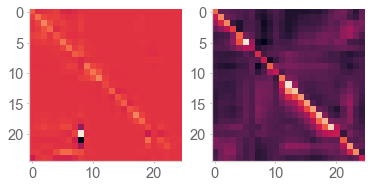

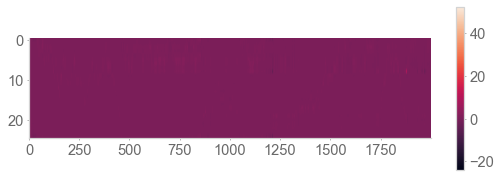

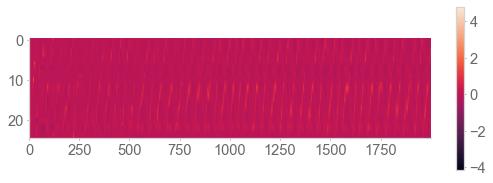

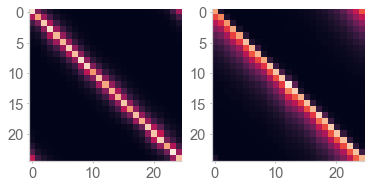

0.17964147299760805

In [43]:
net = STDP_SR(25, 0.8)
run_and_plot(net)

# Truncated Rollout

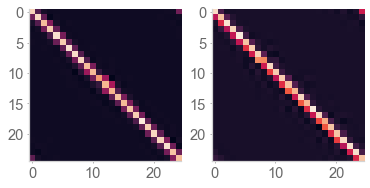

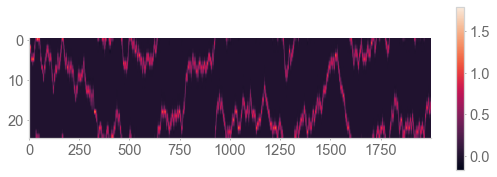

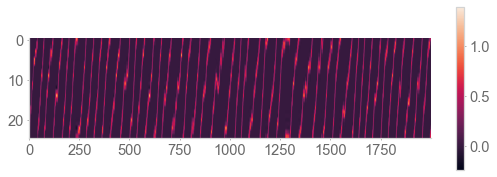

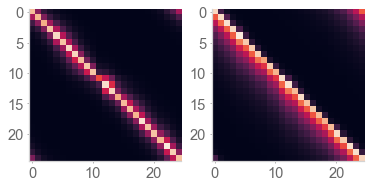

0.1292649980844667

In [44]:
net = STDP_SR(25, 0.8, ca3_kwargs={
    'output_params':{'num_iterations': 2}
        })
run_and_plot(net)

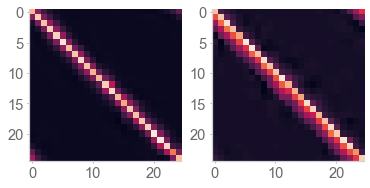

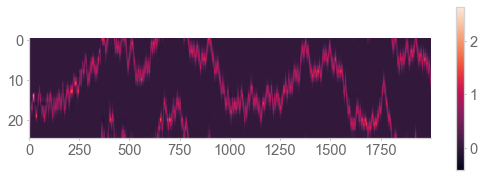

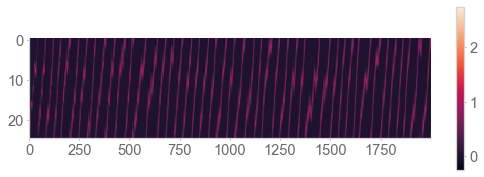

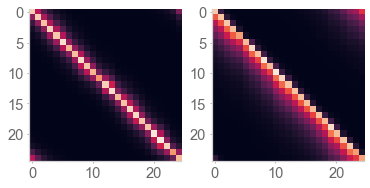

0.08925102140295008

In [45]:
net = STDP_SR(25, 0.8, ca3_kwargs={
    'output_params':{'num_iterations': 4}
        })
run_and_plot(net)

# Tanh Nonlinearity

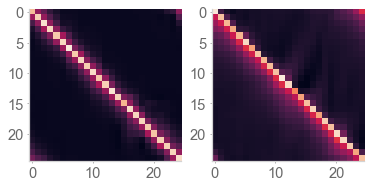

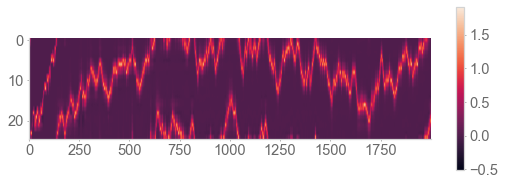

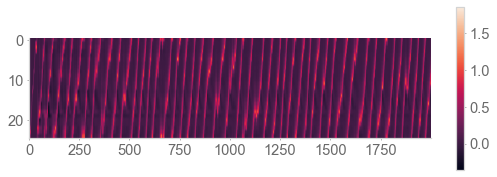

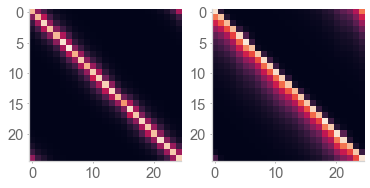

0.06196617801620111

In [46]:
net = STDP_SR(25, 0.8, ca3_kwargs={
'output_params':{'num_iterations': 51,'nonlinearity': 'tanh',
                 'nonlinearity_args': 1.}
    })
run_and_plot(net)